# Анализ изменения количества покупок в течение дня на WB
### для MPSTATS

<b>Контекст:</b> продуктовая команда хочет добавить фичу в инструмент Управление ценой (Репрайсер) – настройку цены на товар в зависимости от времени и дня недели. Для этого нужно изучить нюансы распределения продаж в течение дня.
<br><b>Задача:</b> провести исследование суточной сезонности продаж на Wildberries
<br><b>Подзадачи:</b>
1.	Как в среднем распределяются продажи в течение дня?
2.	Меняется ли распределение продаж в течение дня в зависимости от дня недели?
3.	Меняется ли распределение продаж в течение дня в выходные и праздники?
4.	Зависит ли распределение продаж в течение дня от времени года/месяца?
5.	Влияет ли категория товара (предмет или группа предметов) на распределение продаж в течение дня?

##### Данные
<br><b>«test_data.feather»</b> – данные о ненулевых продажах товаров
<br>id – идентификатор товара на Wildberries
<br>data – дата и время обхода товара парсером MPSTATS
<br>sells – изменение остатков товара по сравнению с прошлым обходом (продажи)
<br>date – только дата от второго столбца
<br><b>«sku_subject_info.csv»</b> – данные о принадлежности товаров к предмету (категории)
<br>id – идентификатор товара на Wildberries
<br>subject_id – идентификатор предмета на Wildberries
<br><b>«subject_names.csv»</b> – данные о предметах
<br>subject_id – идентификатор предмета на Wildberries
<br>name – название предмета
<br>groupname – категория предмета


### 1.Импорт библиотек и источников

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import scipy.stats as st
from urllib.parse import urlencode

In [2]:
# скрываем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [3]:
import requests

public_folder_url = 'https://disk.yandex.ru/d/i9ydGpo04f0sLw'
filename_to_find = 'sku_subject_info.csv'

def get_public_folder_meta(public_url, path=''):
    api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources'
    params = {'public_key': public_url, 'path': path}
    response = requests.get(api_url, params=params)
    response.raise_for_status()
    return response.json()

def find_file_recursively(public_url, folder_meta, filename):
    for item in folder_meta['_embedded']['items']:
        if item['type'] == 'dir':
            # Рекурсивно ищем в подкаталогах
            subfolder_meta = get_public_folder_meta(public_url, item['path'])
            file_url = find_file_recursively(public_url, subfolder_meta, filename)
            if file_url:
                return file_url
        elif item['type'] == 'file' and item['name'] == filename:
            return item['file']
    return None


# Получаем метаданные корневой папки
root_folder_meta = get_public_folder_meta(public_folder_url)

# Ищем файл рекурсивно
file_url = find_file_recursively(public_folder_url, root_folder_meta, filename_to_find)
if file_url:
    # Скачиваем файл
    categories = pd.read_csv(file_url)
    print(f'Файл {filename_to_find} был успешно загружен.')
else:
    print(f'Файл {filename_to_find} не найден.')

Файл sku_subject_info.csv был успешно загружен.


In [4]:
filename_to_find = 'subject_names.csv'
file_url = find_file_recursively(public_folder_url, root_folder_meta, filename_to_find)
if file_url:
    # Скачиваем файл
    subjects = pd.read_csv(file_url)
    print(f'Файл {filename_to_find} был успешно загружен.')
else:
    print(f'Файл {filename_to_find} не найден.')

Файл subject_names.csv был успешно загружен.


In [5]:
filename_to_find = 'test_data.feather'
file_url = find_file_recursively(public_folder_url, root_folder_meta, filename_to_find)
if file_url:
    # Скачиваем файл
    sales = pd.read_feather(file_url)
    print(f'Файл {filename_to_find} был успешно загружен.')
else:
    print(f'Файл {filename_to_find} не найден.')

Файл test_data.feather был успешно загружен.


### 2.Блок исследования и преобразования источников

In [6]:
print(f'categories_table:')
print(categories.isna().sum())
print(f'subjects_table:')
print(subjects.isna().sum())
print(f'sales_table:')
print(sales.isna().sum())

categories_table:
id            0
subject_id    0
dtype: int64
subjects_table:
subject_id     0
name           0
groupname     24
dtype: int64
sales_table:
id       0
data     0
sells    0
date     0
dtype: int64


In [7]:
# размер датафрейма до соединения, сравню размер, не было ли неуникальных значений в справочниках
sales.shape

(13047395, 4)

In [8]:
sales_all = sales.merge(categories, how='left', on='id').merge(subjects, how='left', on='subject_id')
sales_all.head()

,id,data,sells,date,subject_id,name,groupname
0,461732,2022-10-04 04:10:26,3,2022-10-04,98.0,Сабо,Обувь
1,461732,2022-10-04 05:10:26,3,2022-10-04,98.0,Сабо,Обувь
2,461732,2022-10-04 05:12:45,1,2022-10-04,98.0,Сабо,Обувь
3,461732,2022-10-04 06:10:14,1,2022-10-04,98.0,Сабо,Обувь
4,461732,2022-10-04 06:11:50,1,2022-10-04,98.0,Сабо,Обувь


In [9]:
sales_all.shape

(13047395, 7)

таблицы categories и subjects с уникальными значениями, размер sales_all не изменился

In [10]:
sales_all.dtypes

id                     int64
data          datetime64[ns]
sells                  int64
date                  object
subject_id           float64
name                  object
groupname             object
dtype: object

In [11]:
sales_all.data.describe()

count                13047395
unique                3801842
top       2022-10-30 15:12:13
freq                      106
first     2022-06-29 00:16:26
last      2023-06-29 23:33:28
Name: data, dtype: object

In [12]:
sales_all.sells.describe()

count    1.304740e+07
mean     1.117304e+01
std      1.469211e+02
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.100000e+01
max      1.310920e+05
Name: sells, dtype: float64

In [13]:
sales_all.groupname.unique()

array(['Обувь', 'Дом', 'Красота', 'Игрушки', 'Белье', 'Бытовая техника',
       'Товары для малышей', 'Хозяйственные товары',
       'Ювелирные украшения', 'Одежда', 'Рукоделие', 'Техника для кухни',
       'Посуда и инвентарь', 'Спортивная одежда', 'Здоровье', 'Продукты',
       'Канцелярские товары', 'Периферия и аксессуары', 'Детское питание',
       'Головные уборы', 'Аксессуары', 'Книжная продукция и диски',
       'Спортивная обувь', 'Электроника', 'Товары для животных',
       'Спортивное питание и косметика', 'Автомобильные товары',
       'Аксессуары для волос', 'Строительные инструменты',
       'Аксессуары для обуви', 'Шторы и аксессуары', 'Хранение вещей',
       'Оргтехника', 'Смартфоны и аксессуары', 'Спортивный товар',
       'Для праздника', 'Мебель', 'Телевизоры и аудиотехника',
       'Все для садоводства', 'Фото и Видеотехника', 'Белье для малышей',
       'Автоэлектроника', 'Товары для взрослых', 'Спецодежда и СИЗы', nan,
       'Бижутерия', 'Спортивные аксессуары',

Период (data) с  2022-06-29 00:16:26 по 2023-06-29 23:33:28
<br>Кол-во товаров изменялось только в уменьшение значения (все значения в sells со знаком +) от 1 до 131 092

<br>Укрупним data до часов, добавим уровень день недели, месяц, сезон и время суток.

In [14]:
sales_all['data_ymdh'] = sales_all.data.apply(lambda t: datetime.strptime((t.strftime('%m-%d-%Y %H')), '%m-%d-%Y %H'))
# sales_all.data_h = sales_all.data.apply(lambda t: datetime.strptime((t.strftime('%H')), '%H'))
sales_all['data_h'] = sales_all.data.dt.hour
sales_all['data_d'] = sales_all.data.apply(lambda t: datetime.strptime((t.strftime('%m-%d-%Y')), '%m-%d-%Y'))
# sales_all.data_wd = sales_all.data.apply(lambda t: datetime.strptime((t.strftime('%A')), '%A'))
sales_all['data_wd'] = sales_all.data.dt.day_name()
sales_all['data_m'] = sales_all.data.dt.month
sales_all['season'] = sales_all \
    .data_m \
    .apply(lambda s: 'otumn' if (s > 8 and s < 12) else ('summer' if (s > 5 and s < 9) else ('spring' if (s > 2 and s < 6) else 'winter')))
sales_all['day_time'] = sales_all \
    .data_h \
    .apply(lambda s: '1_morning' if (s > 8 and s < 12) else ('2_dinner' if (s > 13 and s < 15) else ('3_day' if (s > 16 and s < 18) else ('4_evening' if (s > 19 and s < 22) else '5_night'))))
sales_all['data_wdn'] = sales_all.data.dt.weekday

In [15]:
# sales_all['season'] = sales_all \
#     .data_m \
#     .apply(lambda s: 'otumn' if (s > 8 and s < 12) else ('summer' if (s > 5 and s < 9) else ('spring' if (s > 2 and s < 6) else 'winter')))

In [16]:
# sales_all['day_time'] = sales_all \
#     .data_h \
#     .apply(lambda s: '1_morning' if (s > 8 and s < 12) else ('2_dinner' if (s > 13 and s < 15) else ('3_day' if (s > 16 and s < 18) else ('4_evening' if (s > 19 and s < 22) else '5_night'))))

In [17]:
# sales_all['data_wdn'] = sales_all.data.dt.weekday

In [18]:
# def season_def(s):
#     if s > 8 and s < 12:
#         return 'otumn'
#     elif s > 5 and s < 9:
#         return 'summer'
#     elif s > 2 and s < 6:
#         return 'spring'
#     else:
#         return 'winter'

In [19]:
sales_all.head()

,id,data,sells,date,subject_id,name,groupname,data_ymdh,data_h,data_d,data_wd,data_m,season,day_time,data_wdn
0,461732,2022-10-04 04:10:26,3,2022-10-04,98.0,Сабо,Обувь,2022-10-04 04:00:00,4,2022-10-04,Tuesday,10,otumn,5_night,1
1,461732,2022-10-04 05:10:26,3,2022-10-04,98.0,Сабо,Обувь,2022-10-04 05:00:00,5,2022-10-04,Tuesday,10,otumn,5_night,1
2,461732,2022-10-04 05:12:45,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 05:00:00,5,2022-10-04,Tuesday,10,otumn,5_night,1
3,461732,2022-10-04 06:10:14,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 06:00:00,6,2022-10-04,Tuesday,10,otumn,5_night,1
4,461732,2022-10-04 06:11:50,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 06:00:00,6,2022-10-04,Tuesday,10,otumn,5_night,1


In [20]:
sales_all.dtypes

id                     int64
data          datetime64[ns]
sells                  int64
date                  object
subject_id           float64
name                  object
groupname             object
data_ymdh     datetime64[ns]
data_h                 int64
data_d        datetime64[ns]
data_wd               object
data_m                 int64
season                object
day_time              object
data_wdn               int64
dtype: object

### 3.Решение подзадач

### <i>1)Как в среднем распределяются продажи в течение дня?</i>

In [21]:
# аггрегируем данные по среднему количеству покупок в час
avg_sales_day = sales_all.groupby('data_h', as_index=False).agg({'sells': 'mean'})
avg_sales_day.head()

,data_h,sells
0,0,4.279422
1,1,4.021161
2,2,4.637351
3,3,5.754495
4,4,7.254959


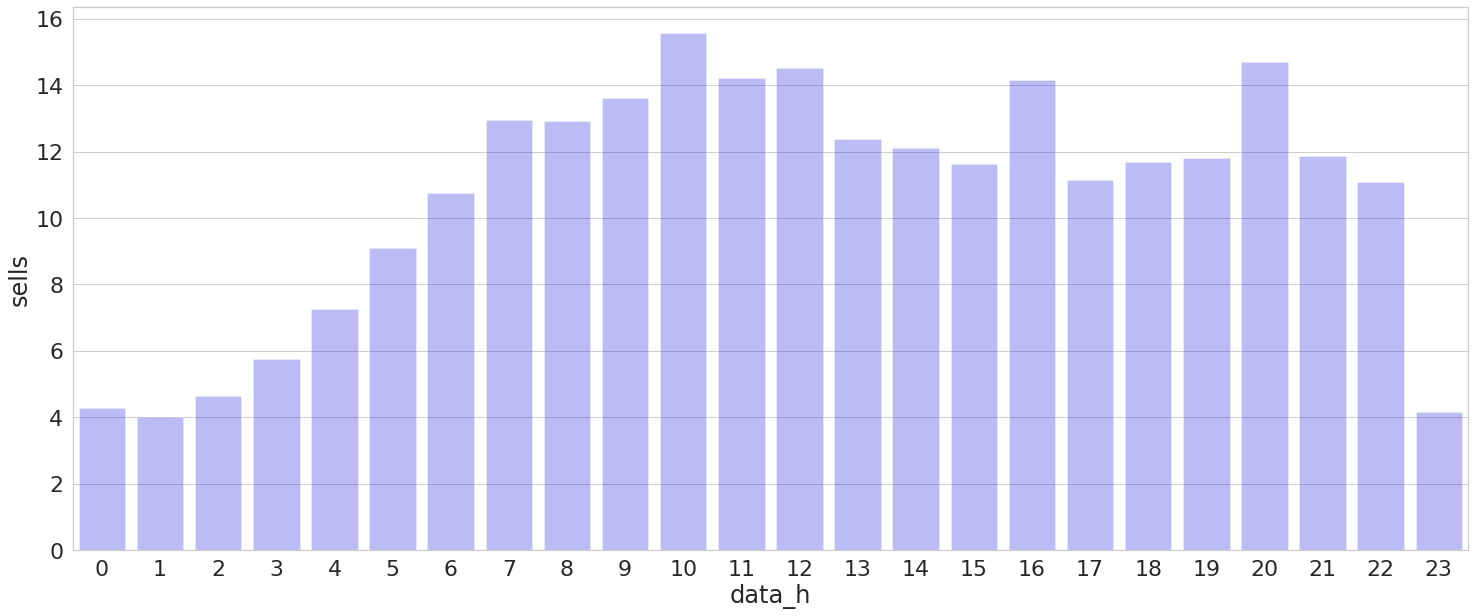

In [22]:
# график
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,10)}
        )

sns.barplot(x='data_h', y='sells', data=avg_sales_day, color='blue', alpha=0.3)

Дневная активность по среднему количству покупок выглядит довольно равномерной со спадом в обед.
<br>Ночью наблюдаем спад активности.
<br>В целом график выглядит довольно логично в зависимости от биоритмов, графика работы-отдыха, бизнес-активности. И если говорить неформально соответствует в том числе и моей активности.
<br>Нахожу интересным рост количества покупок в 16 часов (получается с 15 до 16), для начала посмотрела бы здесь сегмент покупателей по демографичским признакам.
<br>Можно использовать эти данные для группировки суточных периодов (выше добавила отметку утро, обед, день, вечер, ночь)

### <i>2)Меняется ли распределение продаж в течение дня в зависимости от дня недели?</i>

In [23]:
# аггрегируем данные по среднему количеству покупок в час
avg_sales_wd = sales_all.groupby(['data_wd', 'data_wdn', 'day_time'], as_index=False).agg({'sells': 'mean'}).sort_values(['data_wdn', 'day_time'])
avg_sales_wd.head(8)

,data_wd,data_wdn,day_time,sells
5,Monday,0,1_morning,14.269427
6,Monday,0,2_dinner,12.134874
7,Monday,0,3_day,11.048464
8,Monday,0,4_evening,13.840538
9,Monday,0,5_night,10.433047
25,Tuesday,1,1_morning,14.127757
26,Tuesday,1,2_dinner,12.040868
27,Tuesday,1,3_day,11.428285


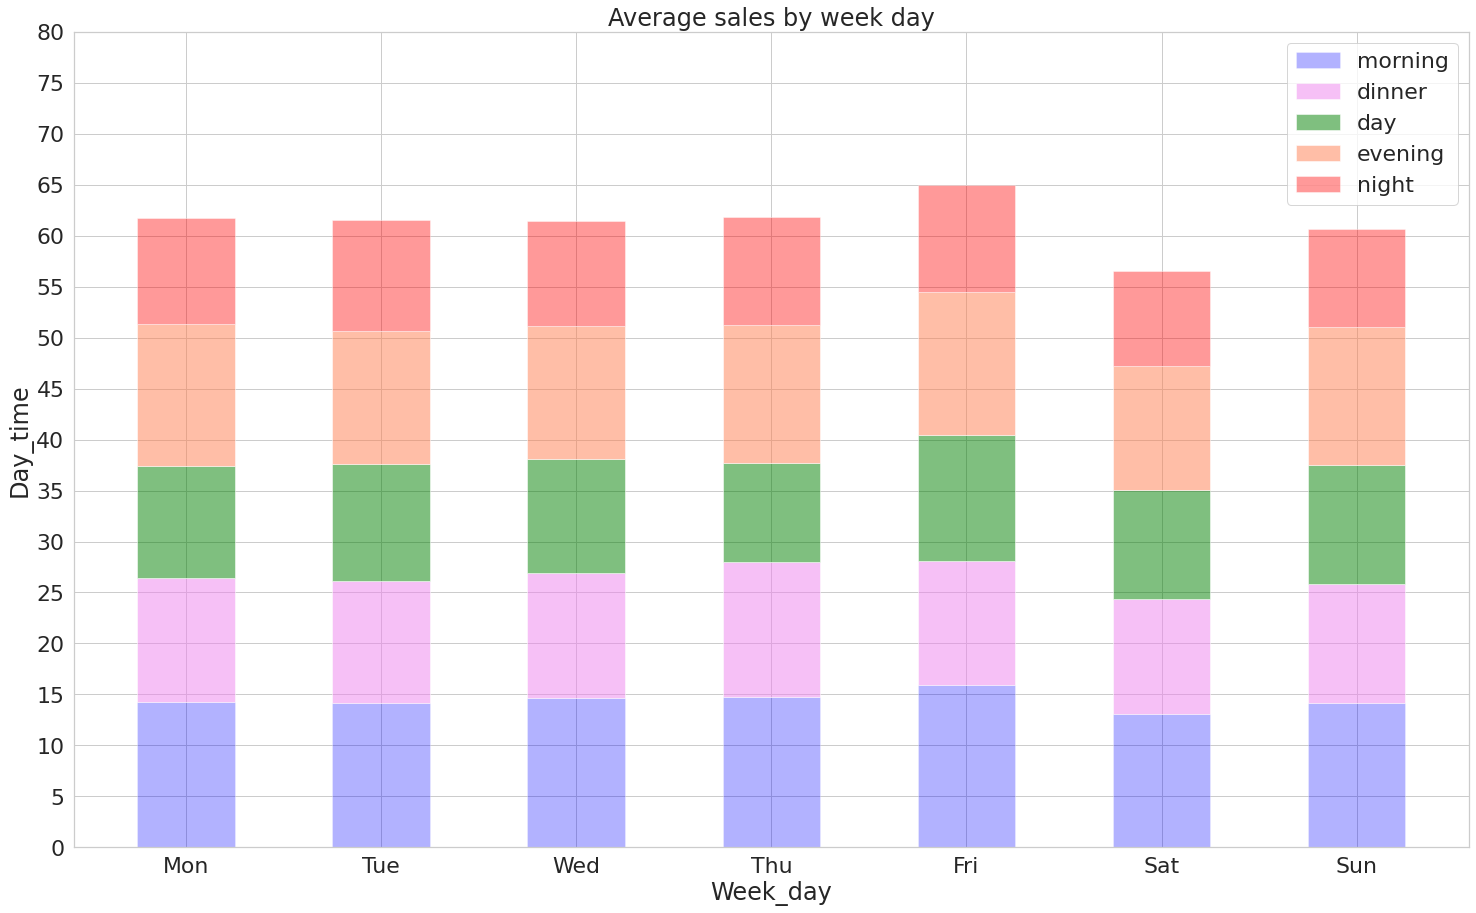

In [24]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,15)}
        )

#задаём сеты значений
morning = list(avg_sales_wd.query("day_time == '1_morning'").sells)
dinner = list(avg_sales_wd.query("day_time == '2_dinner'").sells)
day = list(avg_sales_wd.query("day_time == '3_day'").sells)
evening = list(avg_sales_wd.query("day_time == '4_evening'").sells)
night = list(avg_sales_wd.query("day_time == '5_night'").sells)

#параметры
# N = 4 
# barWidth = .5
# xloc = np.arange (N)

#настраиваем отображение графика
p1 = plt.bar (np.arange (7), morning, width=.5, color='blue', alpha=0.3)
p2 = plt.bar (np.arange (7), dinner, bottom=morning, width=.5, color='violet', alpha=0.5)
p3 = plt.bar (np.arange (7), day, bottom=list(map(sum, zip(morning, dinner))), width=.5, color='green', alpha=0.5)
p4 = plt.bar (np.arange (7), evening, bottom=list(map(sum, zip(morning, dinner, day))), width=.5, color='coral', alpha=0.5)
p5 = plt.bar (np.arange (7), night, bottom=list(map(sum, zip(morning, dinner, day, evening))), width=.5, color='red', alpha=0.4)

#добавляем подписи осей, графика, легенду
plt.ylabel('Day_time')
plt.xlabel('Week_day')
plt.title('Average sales by week day')
plt.xticks (np.arange (7),('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.yticks (np.arange (0, 85, 5))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]),('morning', 'dinner', 'day', 'evening', 'night'))

plt.show()

Укрупнила данные до времени суток, чтобы было удобнее оценивать график
<br>С понедельника по вторник распределение количества продаж в течение дня идентичны.
<br>В пятницу заметный рост активности утром, после обеда - в целом количество продаж больше в течение дня.
<br>'1_morning' 8-12
<br>'2_dinner' 13-15
<br>'3_day' 16-18
<br>'4_evening' 19-22
<br>'5_night' 23-7

<br>Что касается выходных - спад продаж в субботу в течение всего дня, воскресение похоже на среду.
<br><b>Вывод:</b> по графику нельзя сделать вывод, что распределение продаж в течение дня меняется в зависимости от дня недели. Скорее общее количество продаж меняется в зависимости от дня недели.

### <i>3)Меняется ли распределение продаж в течение дня в выходные и праздники?</i>

In [25]:
# загрузим календарь с праздничными и выходными днями
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/KGmBRJCZ4mtYeQ'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

calendar = pd.read_excel(download_url)

In [26]:
calendar = calendar.fillna(0)
calendar.tail()

,date,week_day,mark
725,2023-12-27,среда,0.0
726,2023-12-28,четверг,0.0
727,2023-12-29,пятница,0.0
728,2023-12-30,суббота,1.0
729,2023-12-31,воскресенье,1.0


In [27]:
calendar.dtypes

date        datetime64[ns]
week_day            object
mark               float64
dtype: object

In [28]:
# добавляем выходные к общей таблице
sales_holyday = sales_all.merge(calendar, how='left', left_on='data_d', right_on='date')
sales_holyday.head()

,id,data,sells,date_x,subject_id,name,groupname,data_ymdh,data_h,data_d,data_wd,data_m,season,day_time,data_wdn,date_y,week_day,mark
0,461732,2022-10-04 04:10:26,3,2022-10-04,98.0,Сабо,Обувь,2022-10-04 04:00:00,4,2022-10-04,Tuesday,10,otumn,5_night,1,2022-10-04,вторник,0.0
1,461732,2022-10-04 05:10:26,3,2022-10-04,98.0,Сабо,Обувь,2022-10-04 05:00:00,5,2022-10-04,Tuesday,10,otumn,5_night,1,2022-10-04,вторник,0.0
2,461732,2022-10-04 05:12:45,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 05:00:00,5,2022-10-04,Tuesday,10,otumn,5_night,1,2022-10-04,вторник,0.0
3,461732,2022-10-04 06:10:14,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 06:00:00,6,2022-10-04,Tuesday,10,otumn,5_night,1,2022-10-04,вторник,0.0
4,461732,2022-10-04 06:11:50,1,2022-10-04,98.0,Сабо,Обувь,2022-10-04 06:00:00,6,2022-10-04,Tuesday,10,otumn,5_night,1,2022-10-04,вторник,0.0


In [29]:
# аггрегируем данные по среднему количеству покупок в праздники и будни
avg_sales_holyday = sales_holyday.groupby(['mark', 'day_time'], as_index=False).agg({'sells': 'mean'}).sort_values(['mark', 'day_time'])
avg_sales_holyday.head(20)

,mark,day_time,sells
0,0.0,1_morning,14.683080
1,0.0,2_dinner,12.308229
2,0.0,3_day,10.999152
3,0.0,4_evening,13.592047
4,0.0,5_night,10.506142
5,1.0,1_morning,13.839312
6,1.0,2_dinner,11.679165
7,1.0,3_day,11.467510
8,1.0,4_evening,12.645976
9,1.0,5_night,9.639406


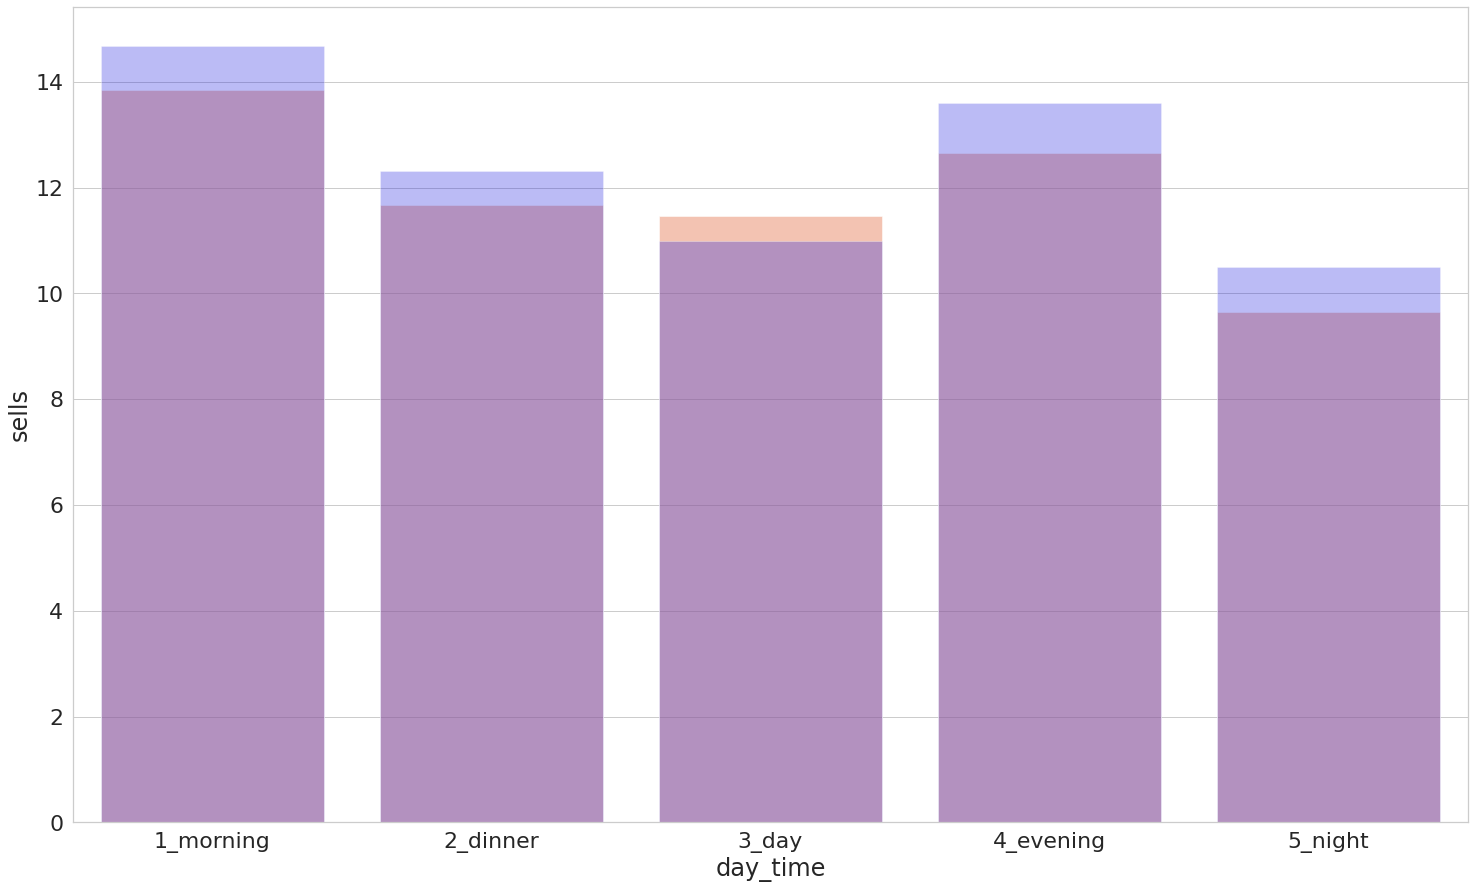

In [30]:
hol = avg_sales_holyday.query('mark == 1')
non_hol = avg_sales_holyday.query('mark != 1')

sns.barplot(x='day_time', y='sells', data=hol, color='coral', alpha=0.5)
sns.barplot(x='day_time', y='sells', data=non_hol, color='blue', alpha=0.3)

По графику заметно, что среднее количество продаж в течение дня выше в непраздничные дни за иключнием временного промежутка с 16 до 18.
<br><b>Вывод:</b> будет схож с предыдущим пунктом. по графику нельзя сделать вывод, что распределение продаж в течение дня меняется в зависимости от покупок в будний или выходной/праздничный день. Скорее общее количество продаж меняется в зависимости от буднего или выходного/праздничного дня. С оговоркой, что есть изменение в промежутке с 16 до 18 дня в праздничные/выходные дни активность выше, тогда как в другое время ниже.

### <i>4)Зависит ли распределение продаж в течение дня от времени года/месяца?</i>

In [31]:
# аггрегируем данные по среднему количеству покупок в час
avg_sales_season = sales_all.groupby(['season', 'day_time'], as_index=False).agg({'sells': 'mean'}).sort_values(['season', 'day_time'])
avg_sales_season.head(20)

,season,day_time,sells
0,otumn,1_morning,12.063349
1,otumn,2_dinner,12.602426
2,otumn,3_day,8.090608
3,otumn,4_evening,16.470351
4,otumn,5_night,9.904670
5,spring,1_morning,16.589366
6,spring,2_dinner,12.832979
7,spring,3_day,14.337148
8,spring,4_evening,8.759153
9,spring,5_night,11.325384


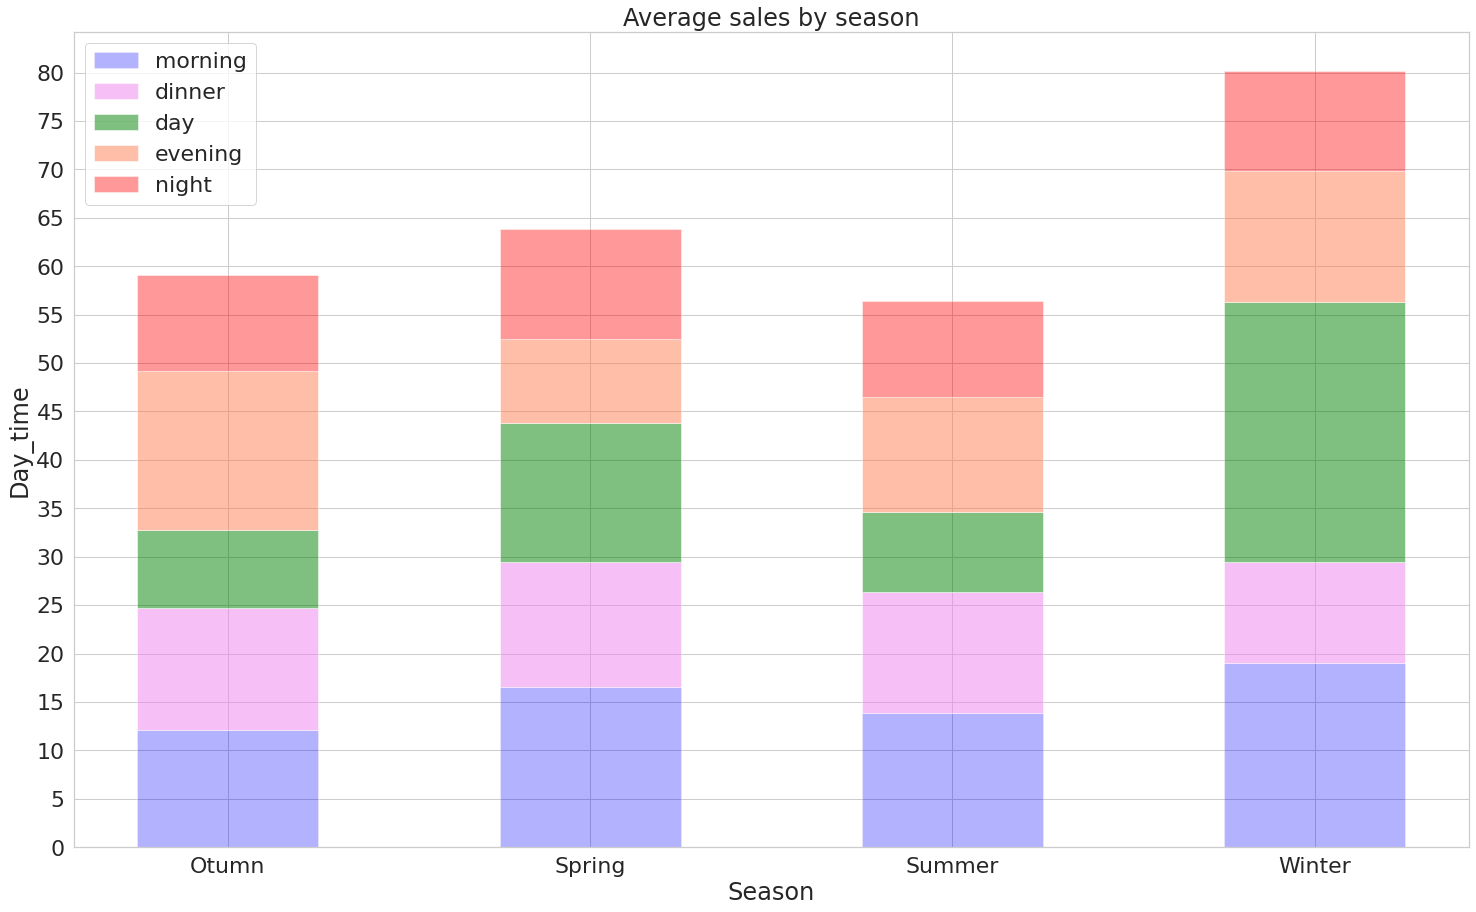

In [32]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,15)}
        )

#задаём сеты значений
morning = list(avg_sales_season.query("day_time == '1_morning'").sells)
dinner = list(avg_sales_season.query("day_time == '2_dinner'").sells)
day = list(avg_sales_season.query("day_time == '3_day'").sells)
evening = list(avg_sales_season.query("day_time == '4_evening'").sells)
night = list(avg_sales_season.query("day_time == '5_night'").sells)

#параметры
# N = 4 
# barWidth = .5
# xloc = np.arange (N)

#настраиваем отображение графика
p1 = plt.bar (np.arange (4), morning, width=.5, color='blue', alpha=0.3)
p2 = plt.bar (np.arange (4), dinner, bottom=morning, width=.5, color='violet', alpha=0.5)
p3 = plt.bar (np.arange (4), day, bottom=list(map(sum, zip(morning, dinner))), width=.5, color='green', alpha=0.5)
p4 = plt.bar (np.arange (4), evening, bottom=list(map(sum, zip(morning, dinner, day))), width=.5, color='coral', alpha=0.5)
p5 = plt.bar (np.arange (4), night, bottom=list(map(sum, zip(morning, dinner, day, evening))), width=.5, color='red', alpha=0.4)

#добавляем подписи осей, графика, легенду
plt.ylabel('Day_time')
plt.xlabel('Season')
plt.title('Average sales by season')
plt.xticks (np.arange (4),('Otumn', 'Spring', 'Summer', 'Winter'))
plt.yticks (np.arange (0, 85, 5))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]),('morning', 'dinner', 'day', 'evening', 'night'))

plt.show()

По графику можно увидеть различия в распределении среднего количества продаж в течение суток между разными сезонами.
<br>Проверим статистическим критерием.

<br>Будем использовать Хи-квадрат тест на независимость (он же test of independence/association) — непараметрический, одновыборочный тест, который проверяет наличие связи между двумя категориальными переменными.

<br>H0 зависимости между переменными нет

In [33]:
#преобразовываем таблицу 
season_chi2 = avg_sales_season.pivot(index='day_time', columns='season', values='sells')
season_chi2

season,otumn,spring,summer,winter
day_time,,,,
1_morning,12.063349,16.589366,13.851048,19.058249
2_dinner,12.602426,12.832979,12.465812,10.402743
3_day,8.090608,14.337148,8.290653,26.858757
4_evening,16.470351,8.759153,11.862647,13.502118
5_night,9.904670,11.325384,9.913954,10.361672


In [34]:
# делаем из датафрэйма многмерный массив
row_array = season_chi2.values
row_array

array([[12.06334857, 16.58936559, 13.85104786, 19.05824918],
       [12.6024265 , 12.83297858, 12.46581208, 10.4027432 ],
       [ 8.09060766, 14.33714837,  8.29065294, 26.85875675],
       [16.47035122,  8.75915287, 11.8626467 , 13.50211796],
       [ 9.90467042, 11.32538419,  9.91395413, 10.36167178]])

In [35]:
stat, p, dof, expected = st.chi2_contingency(row_array)
stat, p

(14.729650041073647, 0.25655512960881727)

Получаем p-value 0.256, подтверждаем H0, зависимости между переменными нет.
<br><b>Вывод:</b> сезон не влияет на распределение продаж в течение суток.

### <i>5)Влияет ли категория товара (предмет или группа предметов) на распределение продаж в течение дня?</i>

In [36]:
# аггрегируем данные по среднему количеству покупок в праздники и будни
avg_sales_cat = sales_holyday.groupby(['groupname', 'day_time'], as_index=False).agg({'sells': 'mean'}).sort_values(['groupname', 'day_time'])
avg_sales_cat.head(20)

,groupname,day_time,sells
0,Автомобильные товары,1_morning,9.885925
1,Автомобильные товары,2_dinner,9.706601
2,Автомобильные товары,3_day,8.892841
3,Автомобильные товары,4_evening,10.107732
4,Автомобильные товары,5_night,7.003860
5,Автоэлектроника,1_morning,4.961165
6,Автоэлектроника,2_dinner,4.021739
7,Автоэлектроника,3_day,3.900000
8,Автоэлектроника,4_evening,6.722628
9,Автоэлектроника,5_night,4.439184


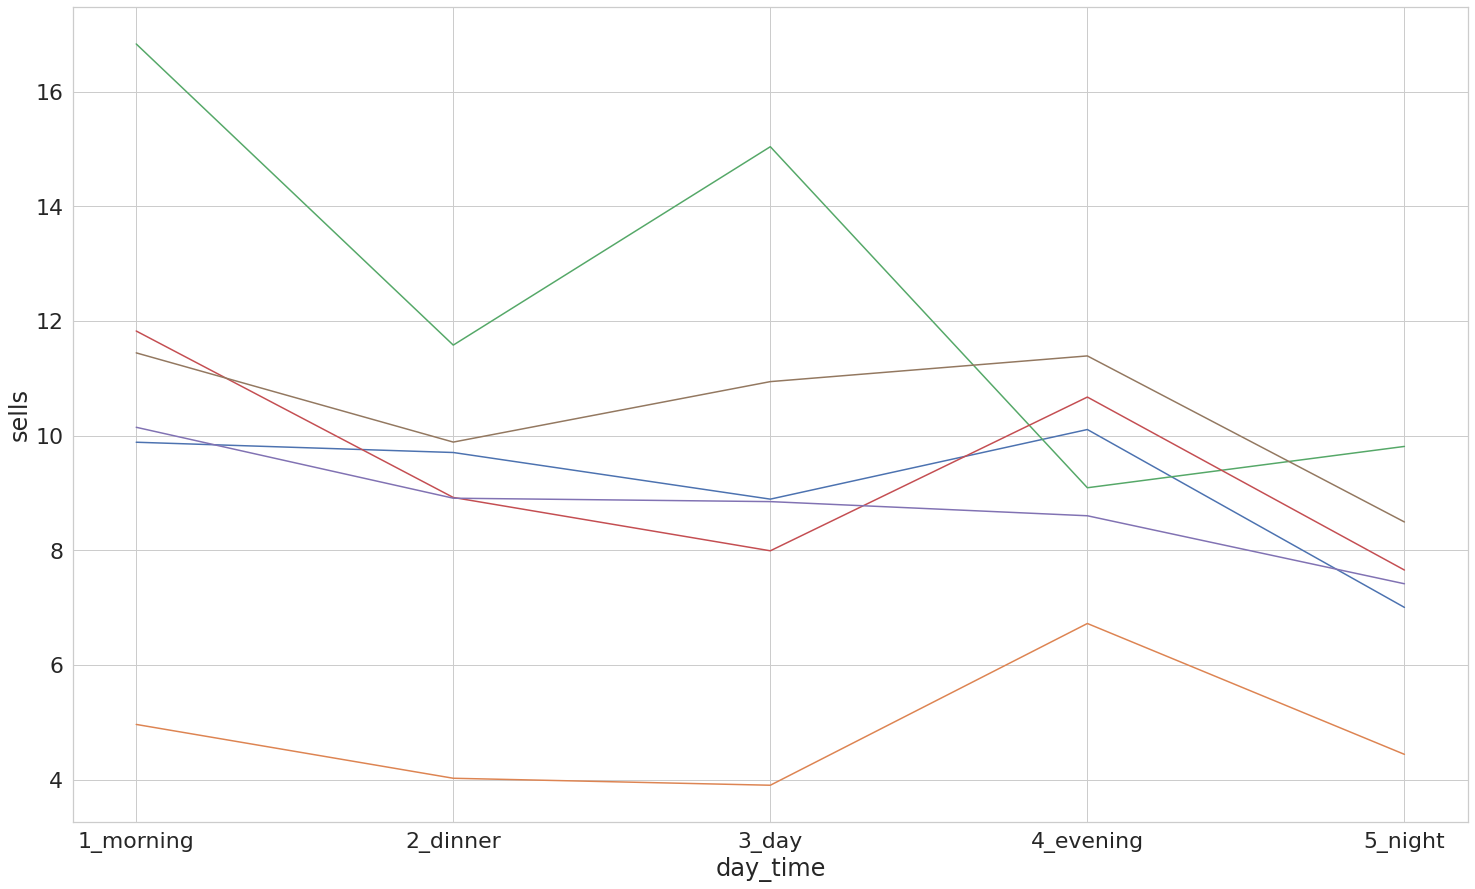

In [46]:
sns.lineplot(data=avg_sales_cat.query('groupname == "Автомобильные товары"'), x='day_time', y='sells')
sns.lineplot(data=avg_sales_cat.query('groupname == "Автоэлектроника"'), x='day_time', y='sells')
sns.lineplot(data=avg_sales_cat.query('groupname == "Аксессуары"'), x='day_time', y='sells')
sns.lineplot(data=avg_sales_cat.query('groupname == "Аксессуары для волос"'), x='day_time', y='sells')
sns.lineplot(data=avg_sales_cat.query('groupname == "Обувь"'), x='day_time', y='sells')
sns.lineplot(data=avg_sales_cat.query('groupname == "Дом"'), x='day_time', y='sells')

Хи-квадрат такую таблицу не обработал, взяла бы таймаут подумать над методологией статистической проверки.
<br>Однако даже на выборке из 6 категорий товаров на графике  заметно, что тенденция в покупку отличается, поэтому ожидаемый результат: категория товара влияет на распределение продаж в течение дня.